In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
import seaborn as sns

from toydown import GeoUnit, ToyDown

In [2]:
def create_demo_tree_homogenous_branching_w_tot(h=3, k=2):
    """ Creates a demo tree of height h <= 16, with homogenous branching of h.
        This demo tree has two population counts, and count that is the sum of them.
    """
    leaves = ["1" + "".join(a) for a in itertools.product(string.hexdigits[1:h+1], repeat=h-1)]
    leaves_counts = np.random.randint(1000, size=(len(leaves),k))
    leaves_attrs = np.insert(leaves_counts, 0, leaves_counts.sum(axis=1), axis=1)
    
    leaf_dict = {i: j for i, j in zip(leaves, leaves_attrs)}
    return create_tree_from_leaves(leaf_dict)

In [3]:
def create_demo_tree_homogenous_branching_no_tot(h=3, k=2):
    """ Creates a demo tree of height h <= 16, with homogenous branching of h.
        This demo tree has two population counts
    """
    leaves = ["1" + "".join(a) for a in itertools.product(string.hexdigits[1:h+1], repeat=h-1)]
    leaves_counts = np.random.randint(1000, size=(len(leaves),k))
#     leaves_attrs = np.insert(leaves_counts, 0, leaves_counts.sum(axis=1), axis=1)
    
    leaf_dict = {i: j for i, j in zip(leaves, leaves_counts)}
    return create_tree_from_leaves(leaf_dict)

In [4]:
def create_tree_from_leaves(leaf_dict):
    """ Given a dictionary, where the keys are the names of leaf nodes (labeled by their path)
        and the corresponding value is the associated attribute counts, this function returns
        the list of GeoUnits that defines the corresponding tree.
    """
    nodes = leaf_dict.copy()
    h = len(list(leaf_dict.keys())[0])
    n = len(list(leaf_dict.values())[0])
    
    for i in range(2, h+1):
        level_names = list(set(list(map(lambda s: s[:-(i-1)], leaf_dict.keys()))))
        level_counts = [np.zeros(n)]*len(level_names)
        for node in level_names:
            nodes[node] = np.array([v for k, v in leaf_dict.items() if k.startswith(node)]).sum(axis=0)
        
    return [GeoUnit(k, k[:-1], v) if k != "1" else GeoUnit(k, None, v) for k, v in nodes.items()]

In [5]:
geounits_tot = create_demo_tree_homogenous_branching_w_tot(3)
geounits_tot.reverse()
geounits_no_tot = create_demo_tree_homogenous_branching_no_tot(3)
geounits_no_tot.reverse()
eps = 1
eps_split = [0.25, 0.25, 0.5]

In [6]:
model = ToyDown(geounits_tot, 3, eps, eps_split)
model_no_tot = ToyDown(geounits_no_tot, 3, eps, eps_split)

model.show()

1
├── 11
│   ├── 111
│   ├── 112
│   └── 113
├── 12
│   ├── 121
│   ├── 122
│   └── 123
└── 13
    ├── 131
    ├── 132
    └── 133



In [7]:
## Constraints: 0 difference among partition bins
## number of children n, returns list of 0 diff constraints.
cons_0_diff = lambda n: [{'type': 'eq', 'fun': lambda x, i=i:  x[i] - np.sum([x[j] for j in range(i+1,i+3)])} 
                         for i in np.arange(n*3, step=3)]

In [8]:
model.noise_and_adjust(node_cons=cons_0_diff, verbose=True)

Adjusting root node 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.798706677294831
            Iterations: 5
            Function evaluations: 27
            Gradient evaluations: 5
Adjusting children of 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 22.085156661990368
            Iterations: 44
            Function evaluations: 513
            Gradient evaluations: 44
Adjusting children of 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.11959010914039
            Iterations: 40
            Function evaluations: 468
            Gradient evaluations: 40
Adjusting children of 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.6990079232879793
            Iterations: 39
            Function evaluations: 461
            Gradient evaluations: 39
Adjusting children of 11
Optimization terminated successfully.

In [9]:
model_no_tot.noise_and_adjust(verbose=True)

Adjusting root node 1
Adjusting children of 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 31.36523068109068
            Iterations: 41
            Function evaluations: 357
            Gradient evaluations: 41
Adjusting children of 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.372020579650389
            Iterations: 45
            Function evaluations: 394
            Gradient evaluations: 45
Adjusting children of 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 11.143523827346458
            Iterations: 40
            Function evaluations: 348
            Gradient evaluations: 40
Adjusting children of 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.967662568204958
            Iterations: 39
            Function evaluations: 338
            Gradient evaluations: 39


In [10]:
leaves = ["1" + "".join(a) for a in itertools.product(string.hexdigits[1:3+1], repeat=3-1)]

In [11]:
leaf_error_tot_cons = np.array([])
leaf_error_a_cons = np.array([])
leaf_error_b_cons = np.array([])
for i in range(1000):
    model.noise_and_adjust(node_cons=cons_0_diff)
    for l in leaves:
        leaf_error_tot_cons = np.append(leaf_error_tot_cons, model.get_node(l).data.error[0])
        leaf_error_a_cons = np.append(leaf_error_a_cons, model.get_node(l).data.error[1])
        leaf_error_b_cons = np.append(leaf_error_b_cons, model.get_node(l).data.error[2])

In [12]:
leaf_error_tot = np.array([])
leaf_error_a = np.array([])
leaf_error_b = np.array([])
for i in range(1000):
    model_no_tot.noise_and_adjust()
    for l in leaves:
        truth = model_no_tot.get_node(l).data.attributes
        adjusted = model_no_tot.get_node(l).data.adjusted
        truth = np.insert(truth, 0, truth.sum())
        adjusted = np.insert(adjusted, 0, adjusted.sum())
        error = truth - adjusted
        
        leaf_error_tot = np.append(leaf_error_tot, error[0])
        leaf_error_a = np.append(leaf_error_a, error[1])
        leaf_error_b = np.append(leaf_error_b, error[2])

/cluster/tufts/rt/software/jupyter3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


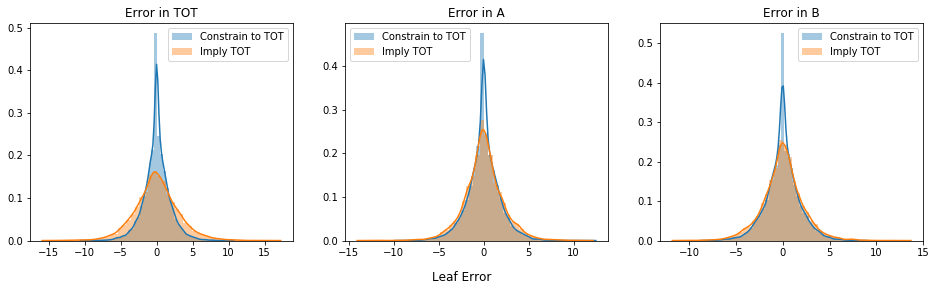

In [13]:
fig, axs = plt.subplots(1,3, figsize=(16,4))
fig.suptitle("Leaf Error", y=0.02)
axs[0].set_title("Error in TOT")
axs[1].set_title("Error in A")
axs[2].set_title("Error in B")
sns.distplot(leaf_error_tot_cons, ax=axs[0], label="Constrain to TOT")
sns.distplot(leaf_error_tot, ax=axs[0], label="Imply TOT")
sns.distplot(leaf_error_a_cons, ax=axs[1], label="Constrain to TOT")
sns.distplot(leaf_error_a, ax=axs[1], label="Imply TOT")
sns.distplot(leaf_error_b_cons, ax=axs[2], label="Constrain to TOT")
sns.distplot(leaf_error_b, ax=axs[2], label="Imply TOT")
for i in range(3):
    axs[i].legend()
    
plt.savefig("plots/leaf_error_abtot_model.png", dpi=200)
plt.show()